In [23]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.draw import polygon2mask
from skimage.measure import find_contours

import stackview

from read_roi import read_roi_zip


In [8]:
FOLDER = Path("C:/Users/jmc010/Data/fostrap/FT112")


In [10]:
def get_sections(folder):
    
    contents = os.listdir(folder / "hires" / "chan1")
    
    sections = [f.split("_")[2] for f in contents if f.endswith("masks.png")]
    return sections

def parse_roi_name(roiname):
    
    section = roiname.split("_")[0]
    region = "".join(roiname.split("_")[1:]).split("-")[0]
    
    return section, region

def get_rois(roidata):
    
    regions = []
    for roi in roidata:
        _, region = parse_roi_name(roi)
        regions.append(region)
        
    return list(set(regions))

roipath = FOLDER / "lowres" / "{}_userdefined_ROIs_cleaned.zip".format(FOLDER.name)
roidata = read_roi_zip(roipath)
rois = get_rois(roidata)

In [61]:
print(roidata.keys())

odict_keys(['s001_caudate_put_0', 's001_naccore_1', 's001_nacshell_2', 's001_piriform_3', 's002_caudate_put_4', 's002_caudate_put_5', 's002_naccore_6', 's002_naccore_7', 's002_nacshell_8', 's002_nacshell_9', 's002_piriform_10', 's002_piriform_11', 's003_caudate_put_12', 's003_caudate_put_13', 's003_piriform_14', 's003_piriform_15', 's004_caudate_put_16', 's004_caudate_put_17', 's004_insula_18', 's004_insula_19', 's004_motorctx_20', 's004_motorctx_21', 's005_caudate_put_22', 's005_caudate_put_23', 's007_pv_hypo_24', 's007_pv_hypo_25', 's007_pv_thal_26', 's007_pv_thal_27', 's008_pv_hypo_28', 's008_pv_hypo_29', 's008_pv_thal_30', 's008_pv_thal_31', 's009_pv_hypo_32', 's009_pv_hypo_33', 's009_pv_thal_34', 's009_pv_thal_35', 's010_lat_hypo_36', 's010_lat_hypo_37', 's010_pv_hypo_38', 's010_pv_hypo_39', 's010_pv_thal_40', 's010_pv_thal_41', 's010_sensoryctx_42', 's010_sensoryctx_43', 's011_lat_hypo_44', 's011_lat_hypo_45', 's011_pv_hypo_46', 's011_pv_thal_47', 's011_pv_thal_48', 's011_pv_thal

In [18]:
def get_roi_coords(roi, scale_factor):

    if roi["type"] == "polygon":
        y = [i*scale_factor for i in roi["x"]]
        x = [i*scale_factor for i in roi["y"]]
        xy = [(x,y) for x,y in zip(x,y)]

    elif roi["type"] == "rectangle":
        
        y1, y2 = [i*scale_factor for i in (roi["left"], roi["left"]+roi["width"])]
        x1, x2 = [i*scale_factor for i in (roi["top"], roi["top"]+roi["height"])]

        xy = [(x1,y1), (x2,y1), (x2,y2), (x1,y2)]
    
    return xy

In [76]:
roi = roidata["s001_piriform_3"]
xy = get_roi_coords(roi, 4)

In [77]:
im = imread(FOLDER / "hires" / "chan1" / "FT112_1A_s001.png")
im_mask = imread(FOLDER / "hires" / "chan1" / "FT112_1A_s001_cp_masks.png")

c:\Users\jmc010\AppData\Local\miniconda3\envs\fosquant\Lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [68]:
def get_mean_rois_vect(im, im_rois):
    # Create a mask for pixels that belong to ROIs (excluding background label 0)
    roi_mask = im_rois > 0

    # Calculate the unique labels for the ROIs
    unique_labels = np.unique(im_rois[roi_mask])

    # Calculate the mean values for each ROI
    roi_means = np.array([np.mean(im[im_rois == label]) for label in unique_labels])

    # Create a lookup table to map labels to their corresponding mean values
    lookup_table = np.zeros(im_rois.max() + 1, dtype=roi_means.dtype)
    lookup_table[unique_labels] = roi_means

    # Apply the mean values to the entire image using the lookup table
    im_out = lookup_table[im_rois]

    # Ensure im_out is of the same data type as im
    im_out = im_out.astype(im.dtype)

    return im_out, roi_means

def make_thresholded_mask(im, im_mask, roi_coords, threshold=0):

    mask = polygon2mask(im.shape, roi_coords)
    im_mask_roi = im_mask * mask

    im_mean, _ = get_mean_rois_vect(im, im_mask_roi)

    im_mean_mask = im_mean > threshold

    return im_mask * im_mean_mask

In [78]:
im_mean = make_thresholded_mask(im, im_mask, xy, threshold=0)

In [79]:
def count_neurons(im, roi_coords, verbose=False):

    mask = polygon2mask(im.shape, roi_coords)
    masked_image = im * mask
    
    ncells = len(np.unique(masked_image)) - 1

    if verbose: print("The number of neurons is", ncells)
    
    return ncells, masked_image

count_neurons(im_mask, xy, verbose=True)
count_neurons(im_mean, xy, verbose=True)

The number of neurons is 19
The number of neurons is 19


(19,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [80]:
def normalize_image(image):
    
    normed_im = image/np.max(image) * 255
    
    return np.clip(normed_im, 0, 255)

scale_factor = 4
roi_min_x, roi_max_x = np.min(roi["x"])*scale_factor, np.max(roi["x"])*scale_factor
roi_min_y, roi_max_y = np.min(roi["y"])*scale_factor, np.max(roi["y"])*scale_factor

im1 = im[roi_min_y:roi_max_y, roi_min_x:roi_max_x]
im2 = im_mean[roi_min_y:roi_max_y, roi_min_x:roi_max_x]

In [82]:
stackview.curtain(normalize_image(im1), im2, continuous_update=True, zoom_factor=1, alpha=0.9)

In [65]:
im_mean_all, roi_means = get_mean_rois_vect(im, im_mask)


(array([ 2.,  1.,  1.,  1.,  2.,  1.,  5.,  4.,  3.,  5.,  6.,  5.,  7.,
         3.,  5., 11.,  6.,  5., 11., 16., 16., 13., 18., 17., 31., 29.,
        20., 19., 29., 25., 15., 21., 20., 39., 23., 28., 20., 20., 27.,
        22., 34., 26., 31., 25., 20., 27., 26., 27., 13., 12., 20., 12.,
        15., 13., 15., 10.,  7., 10., 12.,  9., 10.,  6.,  7., 11.,  7.,
         9.,  9.,  8.,  3.,  7.,  5.,  4.,  2.,  4.,  2.,  6.,  3.,  5.,
         3.,  4.,  4.,  2.,  5.,  3.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,
         1.,  3.,  1.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([ 451.26666667,  458.42102703,  465.57538739,  472.72974775,
         479.88410811,  487.03846847,  494.19282883,  501.34718919,
         508.50154955,  515.65590991,  522.81027027,  529.96463063,
         537.11899099,  544.27335135,  551.42771171,  558.58207207,
         565.73643243,  572.89079279,  580.04515315,  587.19951351,
         594.35387387,  601.50823423,  608.66259459,  615.81695495,
         622.97131532,  63

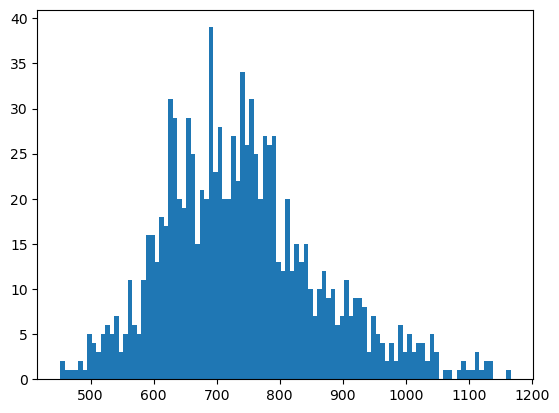

In [66]:
plt.hist(roi_means, bins=100)

In [58]:
np.percentile(roi_means, [1,10,25,50,75,90,99])

array([ 632.128     ,  711.08322981,  790.55555556,  908.91428571,
       1067.64516129, 1245.72333333, 1557.96847771])

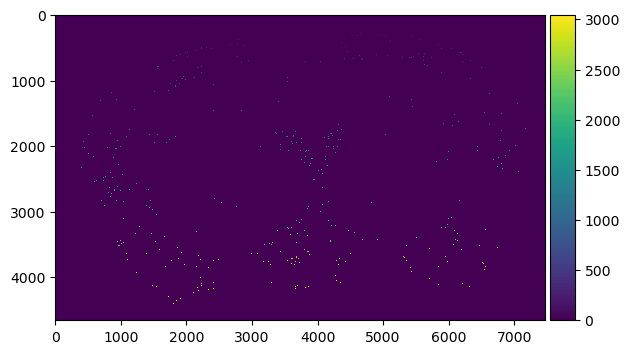

In [31]:
imshow(im_mask)

In [70]:
# get rois
# select arc roi

# re-write count neurons to mask everything outside roi first

# add in thresholding step



c:\Users\jmc010\AppData\Local\miniconda3\envs\fosquant\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


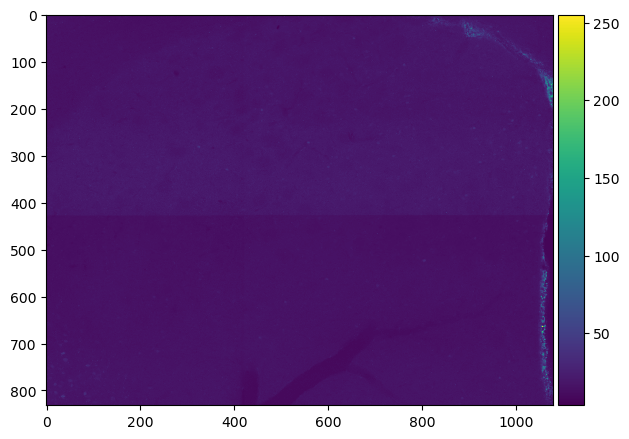

In [73]:
imshow(normalize_image(im1))